# Model Evaluation and Hyperparameter Tuning

# Streamlining workflows with pipelines

**Loading the Breast Cancer Wisconsin dataset**

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

In [2]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [8]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
le.transform(['M', 'B'])

array([1, 0])

In [10]:
from sklearn.cross_validation import train_test_split

D:\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

**Combining transformers and estimators in a pipeline**

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [15]:
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', LogisticRegression(random_state=1))
])

In [16]:
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [17]:
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


# K-fold cross-validation

In [18]:
import numpy as np

In [19]:
from sklearn.cross_validation import StratifiedKFold

In [20]:
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)

In [21]:
scores = []

In [24]:
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    sc = pipe_lr.score(X_train[test], y_train[test])
    scores.append(sc)
    print('Fold: %s, Training Folds Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), sc))

Fold: 1, Training Folds Class dist.: [256 153], Acc: 0.891
Fold: 2, Training Folds Class dist.: [256 153], Acc: 0.978
Fold: 3, Training Folds Class dist.: [256 153], Acc: 0.978
Fold: 4, Training Folds Class dist.: [256 153], Acc: 0.913
Fold: 5, Training Folds Class dist.: [256 153], Acc: 0.935
Fold: 6, Training Folds Class dist.: [257 153], Acc: 0.978
Fold: 7, Training Folds Class dist.: [257 153], Acc: 0.933
Fold: 8, Training Folds Class dist.: [257 153], Acc: 0.956
Fold: 9, Training Folds Class dist.: [257 153], Acc: 0.978
Fold: 10, Training Folds Class dist.: [257 153], Acc: 0.956


In [25]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


**scikit learn implementation**

In [26]:
from sklearn.cross_validation import cross_val_score

In [28]:
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)

In [29]:
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [30]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


# Debugging algorithms with learning and validation curves

**Learning curves (accuracy - number of training samples)**

In [68]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('cla', LogisticRegression(penalty='l2', random_state=0))
])

In [63]:
np.linspace(0.1, 1, 10)

array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [64]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1, 10), cv=10, n_jobs=1)

In [65]:
train_sizes

array([ 40,  81, 122, 163, 204, 245, 286, 327, 368, 409])

In [66]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

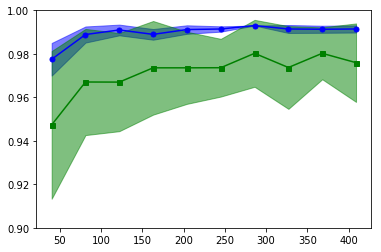

In [67]:
plt.ylim([0.9, 1.0])
plt.plot(train_sizes, train_mean, '-bo', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.5, color='b')
plt.plot(train_sizes, test_mean, '-gs', markersize=5, label='test accuracy')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.5, color='g')
plt.show()

**Validation curves (accuracy - hyperparameter)**

In [70]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10, 100]
train_scores, test_scores = validation_curve(estimator=pipe_lr, X=X_train, y=y_train, param_name='cla__C', param_range=param_range, cv=10)

In [71]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

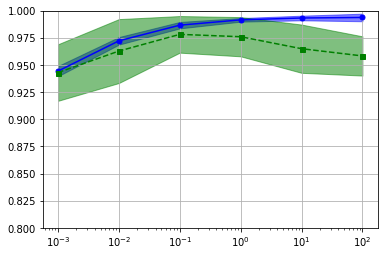

In [76]:
plt.ylim([0.8, 1.0])
plt.plot(param_range, train_mean, '-bo', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.5, color='b')
plt.plot(param_range, test_mean, '--gs', markersize=5, label='test accuracy')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.5, color='g')
plt.xscale('log')
plt.grid()
plt.show()

# Fine-tuning macine learning models via grid search

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [80]:
pipe_svc = Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC(random_state=1))
])

In [81]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = [
    {'clf__C': param_range,
     'clf__kernel': ['linear']},
    {'clf__C': param_range,
     'clf__gamma': param_range,
     'clf__kernel': ['rbf']
    }
]

In [84]:
#from sklearn.model_selection import ParameterGrid
#list(ParameterGrid(param_grid)) # use this to check the generated parameter combinations

In [85]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [86]:
gs = gs.fit(X_train, y_train)

In [87]:
print(gs.best_score_)

0.978021978022


In [88]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [89]:
type(gs.best_estimator_)

sklearn.pipeline.Pipeline

In [90]:
clf = gs.best_estimator_

In [91]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])

In [92]:
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


# Algorithm selection with nested cross-validation

In [93]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=2, n_jobs=-1)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.965 +/- 0.025


In [94]:
from sklearn.tree import DecisionTreeClassifier

In [97]:
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{
                      'max_depth': [1, 2, 3, 4, 5, 6, 7, None]
                  }],
                  scoring='accuracy',
                  cv=2)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy: 0.921 +/- 0.029


# Confusion matrix

In [98]:
from sklearn.metrics import confusion_matrix

In [99]:
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


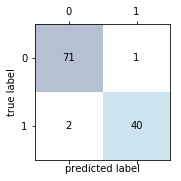

In [105]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i][j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()